# Un premier essai pour identifier les affiliations

## 1. Packages

In [2]:
# !pip install stop_words
# !pip install nltk
# !pip install unidecode
# !pip install elasticsearch

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import math
import time
import random

In [4]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk, parallel_bulk
from collections import deque

In [5]:
# Packages pour le nettoyage des intitulés + méthodes NLP
import re
import nltk
nltk.download('punkt')
from stop_words import get_stop_words
import unicodedata
from nltk.tokenize import word_tokenize

from unidecode import unidecode

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2. Fonctions

In [6]:
def dictionnarize(openstring):
    tolist = openstring.replace('[{', '}, {')
    tolist = tolist.replace('}]', '}, {')
    tolist = tolist.split('}, {')
    tolist = tolist[1:-1]
    return tolist

In [7]:
def clean_explicit_affiliation(s):
    s = s.replace("CIC", "CHU INSERM").replace("APHP", "AP-HP").replace("APHM", "AP-HM")
    s = s.replace("/", "").replace("[", "").replace("]", "")
    return s

In [8]:
def isAffi(alist):
    alist = str(alist)
    return 'AffiliationInfo' in alist

In [9]:
def elastic():
    """Connection avec Elastic sur le data lab"""
    es = Elasticsearch([{'host': 'elasticsearch-master', 'port': 9200, 'scheme': 'http'}], http_compress=True,  request_timeout=200)
    return es

In [10]:
def gen_dict_from_pandas(index_name, df):
    '''
    Lit un dataframe pandas Open Food Facts, renvoi un itérable = dictionnaire des données à indexer, sous l'index fourni
    '''
    for i, row in df.iterrows():
        header= {"_op_type": "index","_index": index_name,"_id": i}
        yield {**header,**row}

In [11]:
def index_elastic(es, index_name: str, setting_file: str, df = pd.DataFrame):
    '''
    Indexe OpenFoodFact dans index_name, à partir du data.frame df, en suivant les instructions d'indexation fournies dans le .json setting_file
    '''
    if es.indices.exists(index = index_name).body:
        es.indices.delete(index = index_name)
        
    with open(setting_file) as f:
        mapping = json.load(f)
    
    es.indices.create(index = index_name, body = mapping)
    
    start_time = time.time()
        
    deque(parallel_bulk(client=es, actions=gen_dict_from_pandas(index_name, df), chunk_size = 2000, thread_count = 4))
    
    print(f"Temps d'exécution total : {(time.time() - start_time):.2f} secondes ---")

In [66]:
def query_scanr(affi):
    myquery = {
        "multi_match" : {
            "query" : affi,
            "fields" : ["label_fr", "label_en", "acronym^3"] 
        }
    }
    queried = es.search(index = "scanr", query = myquery)
    try:
        return queried['hits']['hits'][0]
        # try:
        #     return (first_echo['_score'],first_echo['_source']['label_fr'], first_echo['_source']['acronym'])
        # except:
        #     return (first_echo['_score'],first_echo['_source']['label_fr'])
    except:
        return { "_score": 0, "label" : "PAS DE CORRESPONDANCE" }

In [67]:
def query_scanr_split(affi):
    winner = { "_score": 0, "label" : "PAS DE CORRESPONDANCE" }
    affi_split = affi.split(",")
    for element in affi_split:
        result = query_scanr(element)
        if result['_score'] > winner['_score']:
            winner = result
    return winner

## 3. Importations des données ScanR (source of truth) et de la carto (à identifier)

### 3.1 L'index/source de vérité issu de ScanR

Suite aux échanges avec Eric Jeangirard nous avons eu accès à la base exhaustive de scanR : "https://storage.gra.cloud.ovh.net/v1/AUTH_32c5d10cb0fe4519b957064a111717e3/scanR/organizations.json"
Ces données sont importées et traités dans l'autre programme. Au fur et à mesure des tests réalisés cette base sera corrigée à la main (acronyme manquant, erroné, trop vague, entreprise ETI oubliée, etc) jusqu'à obtenir un index satisfaisant.

In [41]:
index_scanr = pd.read_csv("data/scanr_clean.csv", sep = ",")

In [42]:
index_scanr.head()

label_fr label_en         acronym
0  Centre Hospitalier Universitaire de Martinique      NaN  CHU Martinique
1      Centre hospitalier d'Antibes Juan-les-Pins      NaN             NaN
2                  Centre Hospitalier Alpes-Isère      NaN            CHAI
3         Centre Hospitalier Simone Veil de Blois      NaN        CH Blois
4       Centre hospitalier universitaire d'Angers      NaN      CHU Angers

### 3.2 Les affiliations issues des papiers identifiés, à classer

In [16]:
raw_df = pd.read_json('data/publications.json')

In [17]:
raw_df['affiliated'] = raw_df['AuthorList'].apply(isAffi)

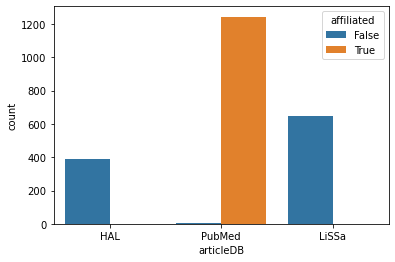

In [18]:
# Seul PubMed publie les affiliation des auteurs, on se restreint à ces observations
_ = sns.countplot(data = raw_df, x = 'articleDB', hue = 'affiliated')

In [19]:
df = raw_df.drop(labels = ['doi'], axis = 1)
df = df[~df['AuthorList'].isnull()]
df = df[df['articleDB'] == "PubMed"]

In [20]:
affiliations = list()
for element in df["AuthorList"]:
    if isinstance(element, dict): # Pour un auteur unique, c'est un dictionnaire directement au lieu d'une liste de dicts
        if ('AffiliationInfo' in element.keys()):
            affiliations.append(clean_explicit_affiliation(element["AffiliationInfo"]["Affiliation"]))
    else:
        for author in element:
            if('AffiliationInfo' in author):
                 if (author['AffiliationInfo'] != None):
                    affiliations.extend(clean_explicit_affiliation(author['AffiliationInfo'][0]).split(";"))   

In [21]:
len(affiliations)

9069

In [22]:
affi_rand = random.choices(affiliations, k = 10)
affi_rand

['Assistance Publique Hôpitaux de Paris, CHU INSERM Cochin-Pasteur, Paris, France.',
 'Department of Gynecology and Obstetrics, Centre Hospitalier Universitaire de Nîmes, University of Montpellier, Nîmes, France.',
 'Santé Publique France, Saint Maurice.',
 "From Caisse Nationale de l'Assurance Maladie (J.R., A.D., J.C., A.W.), Direction de la Stratégie des Études et des Statistiques, Département Études en Santé Publique, Paris",
 'Service de chirurgie thoracique et cardio-vasculaire, CHU Dijon, Dijon, France',
 'Departement of Surgery, Islet Isolation, and Transplantation Center, Geneva University Hospitals, Geneva, Switzerland.',
 'HESPER 7425, Health Services and Performance Research, University Claude Bernard Lyon 1, Lyon, France.',
 'Clinical Research Department, 55647Hospital European Georges Pompidou, Paris, FR.',
 ' Hôpital Robert Debré (D.G.), AP-HP',
 'Department of Infectious Diseases, University Hospital of Saint-Etienne, 42055 Saint-Etienne, France']

## 4. Mise en place de l'Elastic et tests de requêtes

In [23]:
! kubectl get statefulset

NAME                   READY   AGE
elasticsearch-master   3/3     5d22h
jupyter-341697         1/1     28h
jupyter-668414         1/1     2m3s


In [24]:
es = elastic()

In [25]:
#index_elastic(es = es, index_name = "scanr_ngram", setting_file = 'settings_scanr_new.json', df = index_scanr)

/tmp/ipykernel_184/119064481.py:5: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  if es.indices.exists(index = index_name).body:
/tmp/ipykernel_184/119064481.py:6: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.delete(index = index_name)
/tmp/ipykernel_184/119064481.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index = index_name, body = mapping)
/tmp/ipykernel_184/119064481.py:11: ElasticsearchWarning: Elasticsearch built-in security featur

Temps d'exécution total : 0.22 secondes ---


/opt/conda/lib/python3.9/multiprocessing/pool.py:125: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = (True, func(*args, **kwds))


In [68]:
#affi_rand = random.choices(affiliations, k = 20)
for affi in affi_rand:
    print(affi)
    #print(query_scanr_split(affi))
    print(json.dumps(query_scanr_split(affi), indent = 4))

National Jewish Health , Denver , CO , USA.
{
    "_index": "scanr",
    "_type": "_doc",
    "_id": "K6KDZYMBCTGdq5XbFKio",
    "_score": 6.969685,
    "_source": {
        "acronym": "MSD",
        "label_en": "Merck Sharp and Dohme",
        "label_fr": "Merck & Co. Inc."
    }
}
*CépiDc (Epidemiology center on medical causes of death) †UMRS 1018, Inserm ‡Faculty of Medicine Paris Sud, Université Paris Sud, Kremlin-Bicêtre §Haute Autorité de santé (HAS), Saint-Denis La Plaine ∥AP-HP, CHU Bicêtre, Service de Santé Publique et d'Epidémiologie, Kremlin-Bicêtre, France.


/tmp/ipykernel_184/1267180862.py:8: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  queried = es.search(index = "scanr", query = myquery)


{
    "_index": "scanr",
    "_type": "_doc",
    "_id": "-KKDZYMBCTGdq5XbFKao",
    "_score": 22.57387,
    "_source": {
        "acronym": "AP-HP",
        "label_fr": "Assistance Publique \u2013 H\u00f4pitaux de Paris"
    }
}
 Bordeaux PharmacoEpi, Inserm CHU INSERM1401, 33076 Bordeaux, France. Electronic address: julien.bezin@u-bordeaux.fr.
{
    "_index": "scanr",
    "_type": "_doc",
    "_id": "aqKDZYMBCTGdq5XbFKao",
    "_score": 17.405657,
    "_source": {
        "acronym": "INSERM",
        "label_en": "French Institute of Health and Medical Research",
        "label_fr": "Institut national de la sant\u00e9 et de la recherche m\u00e9dicale"
    }
}
Inserm, Bordeaux Population Health Research Center, Team pharmacoepidemiology, University Bordeaux, UMR 1219, F-33000, Bordeaux, France.
{
    "_index": "scanr",
    "_type": "_doc",
    "_id": "aqKDZYMBCTGdq5XbFKao",
    "_score": 17.405657,
    "_source": {
        "acronym": "INSERM",
        "label_en": "French Institute of H

In [27]:
for count, affi in enumerate(affiliations[:500]):
    try:
        hello = query_scanr(affi)
        if(hello["_score"] < 5):
            print("FAIBLE MATCH " + affi)
    except:
        print("!!! PROBLEM " + affi)
        print(count)

/tmp/ipykernel_184/1725084045.py:8: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  queried = es.search(index = "scanr", query = myquery)


FAIBLE MATCH Allergan, an AbbVie company, Courbevoie, France.
FAIBLE MATCH Allergan, an AbbVie company, Courbevoie, France.
FAIBLE MATCH Ophthalmologic Center, Châtellerault, France.
FAIBLE MATCH  and.


In [93]:
affi = "University of Lille, CHU Lille, ULR 2694 - METRICS: Évaluation des technologies de santé et des pratiques médicales, F-59000Lille, France."
affi = "ULR 2694 - METRICS: Évaluation des technologies de santé et des pratiques médicales"
affi = "'CarMen Laboratory, INSERM, INRA, INSA Lyon, Université Claude Bernard Lyon 1, Hôpital Lyon Sud, Pierre-Bénite 69495, France, Hospices Civils de Lyon, Département Endocrinologie, Diabète et Nutrition, Hôpital Lyon Sud, Pierre-Bénite 69495, France, COVID-O-HCL Consortium, Hospices Civils de Lyon, Lyon, France. Electronic address: cyrielle.caussy@chu-lyon.fr.'"

myquery = {
        "multi_match" : {
            "query" : affi,
            "fields" : ["label_fr", "label_en", "acronym^3"] 
        }
    }

#es.search(index = "scanr", query = myquery).body

In [98]:
#es.explain(index = "scanr", query = myquery, id = "q6KDZYMBCTGdq5XbFKao").body
for term in affi.split(','):
    myquery = {
        "multi_match" : {
            "query" : term,
            "fields" : ["label_fr", "label_en", "acronym^3"] 
        }
    }
    try :
        result = es.search(index = "scanr", query = myquery)['hits']['hits'][0]
        print(term)
        print(str(result))
    except:
        print(f" Pas de match pour {term}")

 Pas de match pour 'CarMen Laboratory
 INSERM
{'_index': 'scanr', '_type': '_doc', '_id': 'aqKDZYMBCTGdq5XbFKao', '_score': 17.405657, '_source': {'acronym': 'INSERM', 'label_en': 'French Institute of Health and Medical Research', 'label_fr': 'Institut national de la santé et de la recherche médicale'}}
 Pas de match pour  INRA
 INSA Lyon
{'_index': 'scanr', '_type': '_doc', '_id': 'h6KDZYMBCTGdq5XbFKao', '_score': 22.303726, '_source': {'acronym': 'INSA Lyon', 'label_fr': 'Institut national des sciences appliquées de Lyon'}}
 Université Claude Bernard Lyon 1
{'_index': 'scanr', '_type': '_doc', '_id': 'iKKDZYMBCTGdq5XbFKao', '_score': 21.008982, '_source': {'label_en': 'Claude Bernard University Lyon 1', 'label_fr': 'Université Claude Bernard Lyon 1'}}
 Hôpital Lyon Sud
{'_index': 'scanr', '_type': '_doc', '_id': 'h6KDZYMBCTGdq5XbFKao', '_score': 12.982149, '_source': {'acronym': 'INSA Lyon', 'label_fr': 'Institut national des sciences appliquées de Lyon'}}
 Pierre-Bénite 69495
{'_ind

/tmp/ipykernel_184/1458281292.py:10: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index = "scanr", query = myquery)['hits']['hits'][0]


#### Vadamecum
Traduction des hopitaux en anglais

Problème entre CHU et CHRU Dijon, pareil pour Rennes

(13.256369, ' Unité Inserm U1046, bâtiment Paul-de-Castre, hôpital Arnaud-de-Villeneuve, 375, avenue du Doyen-Gaston-Giraud, 34295 Montpellier cedex 5, France. Electronic address: c-dadure@chu-montpellier.fr.', 'Centre Hospitalier Universitaire de Montpellier', 'CHU Montpellier') attribué à Montpellier...

# 5. MaxAllen

In [73]:
#df = pd.read_csv('https://github.com/allenai/S2AFF/raw/main/data/gold_affiliation_annotations.csv')

In [75]:
# Depuis le dump

url_pubmed = "https://storage.gra.cloud.ovh.net/v1/AUTH_32c5d10cb0fe4519b957064a111717e3/models/pubmed_and_h2020_affiliations.json"
deb = time.time()
df_pubmed = pd.read_json(url_pubmed)
fin = time.time()
print(fin-deb)
#df_scanr.to_csv("dump_scanr.csv", sep = ";", index = False)

0.8907997608184814


In [81]:
df_pubmed['label'][3]

'CarMen Laboratory, INSERM, INRA, INSA Lyon, Université Claude Bernard Lyon 1, Hôpital Lyon Sud, Pierre-Bénite 69495, France, Hospices Civils de Lyon, Département Endocrinologie, Diabète et Nutrition, Hôpital Lyon Sud, Pierre-Bénite 69495, France, COVID-O-HCL Consortium, Hospices Civils de Lyon, Lyon, France. Electronic address: cyrielle.caussy@chu-lyon.fr.'

In [77]:
df_pubmed.head(20)

label          rnsr  \
0   Service de chirurgie vasculaire et endovascula...            []   
1   Service de chirurgie vasculaire et endovascula...            []   
2   Service de chirurgie vasculaire et endovascula...            []   
3   CarMen Laboratory, INSERM, INRA, INSA Lyon, Un...  [201119381Y]   
4   Université Lille, Inserm Pasteur Lille, Inserm...  [201019111J]   
5   Medical Intensive Care Unit, Hôpital Lyon Sud,...            []   
6   CarMen Laboratory, INSERM, INRA, INSA Lyon, Un...  [201119381Y]   
7   Hospices Civils de Lyon, Département Endocrino...            []   
8   Department of Intensive Care, CHU Lille, Lille...            []   
9   Hospices Civils de Lyon, Service de Biostatist...  [199411998X]   
10  Hospices Civils de Lyon, Laboratoire de Virolo...  [201320572J]   
11  FCRIN/FORCE Network, Centre de Recherche en Nu...            []   
12  Laboratoire des Pathogènes Emergents-Fondation...  [201320572J]   
13  CarMen Laboratory, INSERM, INRA, INSA Lyon, Un...  [201119381Y]   
14  CarMen Laboratory, INSERM, INRA, INSA Lyon, Un...  [201119381Y]   
15  COVID-19 Task Force of the Young-Otolaryngolog...            []   
16  Department of Human Anatomy and Experimental O...            []   
17  Department of Otolaryngology-Head and Neck Sur...            []   
18  Department of Otorhinolaryngology and Head and...            []   
19  Department of Neurology, CHU de Charleroi, Cha...            []   

                     siren                          grid country  \
0                       []                            []    [fr]   
1                       []                            []    [fr]   
2                       []                            []    [fr]   
3                       []                            []    [fr]   
4                       []                            []    [fr]   
5                       []                            []    [fr]   
6                       []                            []    [fr]   
7                       []                            []    [fr]   
8              [265906719]                            []    [fr]   
9                       []                            []    [fr]   
10                      []                            []    [fr]   
11             [180089526]                            []    [fr]   
12                      []                            []    [fr]   
13                      []                            []    [fr]   
14                      []                            []    [fr]   
15                      []                            []    [fr]   
16                      []                 [grid.8364.9]    [be]   
17  [197819444, 408457299]                            []    [fr]   
18                      []  [grid.4989.c, grid.50545.31]    [be]   
19                      []               [grid.413871.8]    [be]   

                       ror  source  
0                       []  pubmed  
1                       []  pubmed  
2                       []  pubmed  
3                       []  pubmed  
4                       []  pubmed  
5                       []  pubmed  
6                       []  pubmed  
7                       []  pubmed  
8                       []  pubmed  
9                       []  pubmed  
10                      []  pubmed  
11                      []  pubmed  
12                      []  pubmed  
13                      []  pubmed  
14                      []  pubmed  
15                      []  pubmed  
16             [02qnnz951]  pubmed  
17                      []  pubmed  
18  [01r9htc13, 05cmp5q80]  pubmed  
19             [04t23pb41]  pubmed

original_affiliation  \
0                     Chinese Academy of Sciences (CAS)   
1     Laboratory of Immunologic and Inflammatory Dis...   
2     CCAST (World Laboratory), P.O. Box 8730, Beiji...   
3     Inst. of Comput. Technol., Chinese Acad. of Sc...   
4                           Chinese academy of Sciences   
...                                                 ...   
2359             Politeknik Elektronika Negeri Surabaya   
2360  Tashkent State Transport University, Tashkent,...   
2361                                      IAIN Ponorogo   
2362               Akuntansi, Universitas Islam Bandung   
2363                                              NAIST   

     original_labels_correct  \
0                        yes   
1                         no   
2                         no   
3                         no   
4                        yes   
...                      ...   
2359                     yes   
2360                     yes   
2361                     yes   
2362                      no   
2363                      no   

                                                 labels  split  
0                         {'https://ror.org/034t30j35'}  train  
1     {'https://ror.org/011rf9d86', 'https://ror.org...  train  
2     {'https://ror.org/02egfyg20', 'https://ror.org...  train  
3     {'https://ror.org/0090r4d87', 'https://ror.org...  train  
4                         {'https://ror.org/034t30j35'}  train  
...                                                 ...    ...  
2359         {'Politeknik Elektronika Negeri Surabaya'}    val  
2360            {'Tashkent State Transport University'}  train  
2361                                  {'IAIN Ponorogo'}    val  
2362                      {'https://ror.org/04tp6pr14'}    val  
2363                      {'https://ror.org/05bhada84'}    val  

[2364 rows x 4 columns]

# 6. Comparaison à la méthode précédente

In [28]:
# len_author = 300
# affi_col = list()
# for element in df["AuthorList"][0:len_author]:
#     affi_elem = list()
#     for author in element:
#         if('AffiliationInfo' in author):
#                  if (author['AffiliationInfo'] != None):
#                     query = author['AffiliationInfo'][0].replace("/", "").replace("[", "").replace("]", "")
#                     try :
#                         new_affi = es.search(index = "scanr", q = query)['hits']['hits'][0]['_source']['libelle']
#                     except:
#                         new_affi = "ERREUR"
#                     affi_elem.append(new_affi)
#     affi_elem = set(affi_elem)
#     affi_col.append(affi_elem)

In [29]:
# i = random.randint(0, len_author-1)
# affi_col[i]
# df['AffiliationInfo'].iloc[i]
# df['AuthorList'].iloc[i]

# DEPOTOIR

### (Plus utile car stemming et cleaning dans Elastic) Nettoyage des structures de la carto

In [30]:
def remove_stopwords(s):
    s = [w for w in word_tokenize(s) if w not in stopwords]
    s = ' '.join(s)
    return(s)

In [31]:
def remove_accent(s):
    s = unidecode(s)
    return(s)

In [32]:
def remove_punctuation(s):
    # On retire la ponctuation
    s = re.sub(r'[^A-Za-z,]',' ',str(s))
    return(s)

In [33]:
def tolower(s):
    s = ' '.join(s.lower().split())
    return(s)

In [34]:
df_affi = pd.DataFrame(affiliations)
df_affi.columns = ["Structure"]

In [35]:
df_affi.head()

Structure
0  Direction de la stratégie, des études et des s...
1  Assistance Publique - Hôpitaux de Marseille, H...
2   Aix-Marseille Université, Faculté de Médecine...
3  Aix-Marseille Université, Faculté de Médecine,...
4   Unité d'Analyse des données de Santé, Assista...

In [36]:
stopwords = get_stop_words('french')
stopwords = [unicodedata.normalize('NFKD',m).encode('ASCII', 'ignore').decode() for m in stopwords]

In [37]:
df_affi['Structure'] = df_affi['Structure'].apply(lambda x:remove_accent(str(x)))
df_affi['Structure'] = df_affi['Structure'].apply(lambda x:remove_punctuation(str(x)))
df_affi['Structure'] = df_affi['Structure'].apply(lambda x:remove_stopwords(x))
df_affi['Structure'] = df_affi['Structure'].apply(lambda x:tolower(str(x)))   

In [38]:
df_affi.head(10)

Structure
0  direction strategie , etudes statistiques , ca...
1  assistance publique hopitaux marseille , hopit...
2  aix marseille universite , faculte medecine , ...
3  aix marseille universite , faculte medecine , ...
4  unite analyse donnees sante , assistance publi...
5  unite analyse donnees sante , assistance publi...
6  atmosud , observatoire qualite air region sud ...
7  unite analyse donnees sante , assistance publi...
8  atmosud , observatoire qualite air region sud ...
9  aix marseille universite , faculte medecine , ...